In [1]:
import pandas as pd
import glob
import numpy as np
from sklearn.neighbors import BallTree, KDTree, DistanceMetric
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import subprocess

## Посмотрим на данные

In [4]:
test = pd.concat([pd.read_hdf(file) for file in ['data/dm4/test_close0.h5', 'data/dm4/test_close10.h5']])
test.head()

,TX,TY,X,Y,Z,data_ind
0,0.087240,0.119438,86536.218750,62988.312500,56892.0,0
1,-0.380208,0.198382,93346.765625,58062.937500,14223.0,0
2,-0.348549,-0.099981,66129.578125,23038.673828,46548.0,0
3,0.585342,-0.126879,68825.523438,55186.625000,45255.0,0
4,0.038579,-0.131510,36366.941406,47564.878906,9051.0,0


In [7]:
train = pd.read_hdf('data/dm4/open30.h5')
ind = train[train.data_ind == train.data_ind[0]]

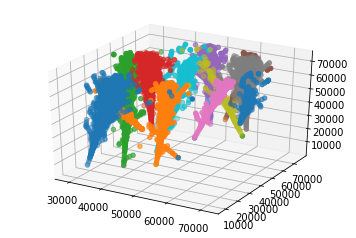

In [8]:
for id_ in ind.event_id.unique()[1:]:
    ev = ind[ind.event_id == id_]
    ax = plt.gca(projection='3d')
    ax.scatter3D(ev.X, ev.Y, ev.Z)

Теперь в одном `data_ind` намного больше ливней. Это сильно усложняет задачу

## Группировка на пары

Нагенерим фичей, как и обсуждалось на семинарах, с помощью BallTree в пространстве координат и углов

In [23]:
from tqdm import tqdm

columns = ['TX', 'TY', 'X', 'Y', 'Z']
for_metric = columns[:-1]

def add_neighbours(df, k, same_pair, metric='minkowski'):
    result = []
    
    for data_ind in tqdm(df.data_ind.unique()):
        ind = df[df.data_ind == data_ind]
        values = list(sorted(ind.Z.unique()))
        for z, z_next in zip(values, values[1:]):
            z, z_next = ind[ind.Z == z].copy(), ind[ind.Z == z_next].copy()
#             1293 is a typical distance between neighbour slices along OZ
            z[['TX', 'TY']] *= 1293
            z_next[['TX', 'TY']] *= 1293
            
            b_tree = BallTree(z_next[for_metric], metric=metric)
            d, idx = b_tree.query(z[for_metric], k=min(k, len(z_next)))
            
            for i in range(idx.shape[1]):
                data = z_next.iloc[idx[:, i]]
                temp = z.copy()
                for col in columns:
                    temp[col + '_pair'] = data[col].values
                if same_pair:
                    temp['same_pair'] = data.event_id.values == z.event_id.values
                result.append(temp)
            
        result.append(z_next)
        
    result = pd.concat(result)
    for col in columns:
        result['d' + col] = result[col].values - result[col + '_pair'].values
    return result

def make_train(df, k):
    t = add_neighbours(df, k=k, same_pair=True)
    noise = t.event_id == -999
    signal, not_signal = t[~noise], t[noise]
    noise_part = not_signal.sample(len(signal))
    return pd.concat([signal, noise_part]).reset_index(drop=True)

In [24]:
train = []
for file in glob.glob('data/dm4/open*.h5')[:5]:
    train.append(make_train(pd.read_hdf(file), k=3))
train = pd.concat(train)

100%|██████████| 10/10 [00:35<00:00,  3.57s/it]


In [25]:
train.head()

,TX,TX_pair,TY,TY_pair,X,X_pair,Y,Y_pair,Z,Z_pair,data_ind,event_id,same_pair,signal,dTX,dTY,dX,dY,dZ
0,-120.490211,74.753609,444.966217,397.600922,38500.425781,40560.890625,25600.734375,47039.101562,3879.000000,4154.886719,21,193609.0,False,1.0,-195.243820,47.365295,-2060.464844,-21438.367188,-275.886719
1,64.776703,74.753609,363.636444,397.600922,40566.082031,40560.890625,47068.250000,47039.101562,3879.000000,4154.886719,21,183053.0,True,1.0,-9.976906,-33.964478,5.191406,29.148438,-275.886719
2,74.753609,-106.954178,397.600922,454.387695,40560.890625,38509.781250,47039.101562,25566.177734,4154.886719,4158.167969,21,183053.0,False,1.0,181.707794,-56.786774,2051.109375,21472.923828,-3.281250
3,-106.954178,-135.986267,454.387695,363.800568,38509.781250,38328.984375,25566.177734,25683.556641,4158.167969,5172.000000,21,195432.0,False,1.0,29.032089,90.587128,180.796875,-117.378906,-1013.832031
4,-106.954178,-117.631310,454.387695,444.702545,38509.781250,38386.769531,25566.177734,26033.638672,4158.167969,5172.000000,21,195432.0,False,1.0,10.677132,9.685150,123.011719,-467.460938,-1013.832031


## Обучение

In [27]:
y_train = train.signal
X_train = train.drop(['event_id', 'signal', 'data_ind', 'same_pair'], axis=1)

In [28]:
lgb_train = lgb.Dataset(X_train, y_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_depth': 15,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 4
}

lgb.cv(params, lgb_train, 20, nfold=5)

{'auc-mean': [0.8338646008533528,
  0.849123688239249,
  0.853427020602072,
  0.8615161770402378,
  0.8638448918523324,
  0.8643885465467575,
  0.8686941501272111,
  0.8706270169567292,
  0.8728827974729875,
  0.8743453960346544,
  0.8749153149522716,
  0.8753295322315002,
  0.8770023677648474,
  0.8779296181944363,
  0.8788094022405201,
  0.8812092313951672,
  0.8824610506081905,
  0.8842410424615096,
  0.8849739946483698,
  0.8862495659000663],
 'auc-stdv': [0.0004791816851679718,
  0.0005634951470198993,
  0.00046498814798688853,
  0.0002740897828683157,
  0.0007799968105814074,
  0.0016524213916289095,
  0.0014213068330513185,
  0.0009495227720941135,
  0.0008124462333478768,
  0.0007830366954841335,
  0.0005948206570365004,
  0.0006081703551135803,
  0.0005124128828150498,
  0.0004995390594613376,
  0.00039527741949930604,
  0.0004111697825083745,
  0.0004352934631004182,
  0.00044262179322309265,
  0.0004975433637533354,
  0.0004284628087590866]}

In [29]:
bst = lgb.train(params, lgb_train, 100)

## Предсказание

In [30]:
test_p = add_neighbours(test, k=3, same_pair=False)

100%|██████████| 11/11 [00:37<00:00,  3.38s/it]


In [31]:
X_test = test_p.drop(['data_ind'], axis=1).reset_index(drop=True)
X_test.head()

,TX,TX_pair,TY,TY_pair,X,X_pair,Y,Y_pair,Z,Z_pair,dTX,dTY,dX,dY,dZ
0,-193.084152,-350.331818,623.975891,437.505890,37949.000000,38081.851562,24967.570312,24522.312500,0.0,1293.0,157.247665,186.470001,-132.851562,445.257812,-1293.0
1,-225.433212,-380.564331,-367.239899,458.562836,39335.953125,39409.578125,49094.968750,49534.917969,0.0,1293.0,155.131119,-825.802734,-73.625000,-439.949219,-1293.0
2,-288.543915,-166.982605,744.821838,638.900269,51992.125000,51851.539062,74045.695312,73873.390625,0.0,1293.0,-121.561310,105.921570,140.585938,172.304688,-1293.0
3,-131.043716,-486.173767,-389.968414,107.317078,29508.035156,29299.156250,67410.984375,67238.296875,0.0,1293.0,355.130066,-497.285492,208.878906,172.687500,-1293.0
4,-233.201782,135.409042,573.095337,775.318970,67685.781250,67272.015625,75164.359375,75664.359375,0.0,1293.0,-368.610840,-202.223633,413.765625,-500.000000,-1293.0


### Агрегируем предсказания

В качестве финального предсказания возьмём среднюю вероятность для каждой точки

In [32]:
pred = bst.predict(X_test)

In [34]:
raw = pd.DataFrame({'id': test_p.index, 'prob': pred}).groupby('id')
# other statistincs were used for visualization
agg = raw.aggregate(('mean', 'max', 'min'))['prob']

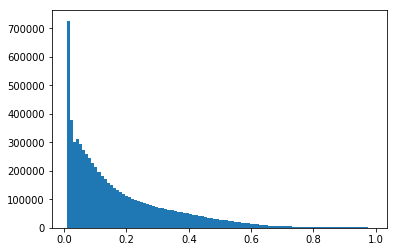

In [36]:
plt.hist(agg['mean'], bins=100);

float16 - чтобы сэкономить место

In [37]:
result = pd.DataFrame(data={'id': agg.index, 'signal': agg['mean'].values.astype('float16')})
result.head()

,id,signal
0,0,0.148682
1,1,0.106079
2,2,0.366699
3,3,0.101196
4,4,0.043793


In [182]:
result_.to_csv('submit.csv', index=False)